In [1]:
import torch
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import scipy.io
import numpy as np

# Load the .mat file
file_path = '/Users/rohitviswam/Desktop/IITM Mat file/EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Inspect the structure of the loaded data
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'EV_re_im_split'])

In [3]:
# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
print(EV_data.shape)

(50, 1000, 832)


In [4]:
data = EV_data

In [5]:
data.shape

(50, 1000, 832)

In [6]:
data=data[:5,:,:1]

In [7]:
data.shape

(5, 1000, 1)

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
data_flattened = data.reshape(data.shape[0], -1)


In [10]:
data = data_flattened

In [11]:
import numpy as np

# Assuming `data` is already loaded as a numpy array with shape (2100, 101888)
num_UEs = data.shape[0]
num_time_steps = data.shape[1]
input_length = 10

# Prepare lists to hold the input-output pairs for each UE
all_inputs = []
all_targets = []

# Iterate through each UE
for ue_idx in range(num_UEs):
    ue_data = data[ue_idx]

    ue_inputs = []
    ue_targets = []

    # Generate input-target pairs
    for start_idx in range(num_time_steps - input_length):
        end_idx = start_idx + input_length
        input_seq = ue_data[start_idx:end_idx]
        target_value = ue_data[end_idx]

        ue_inputs.append(input_seq)
        ue_targets.append(target_value)

    # Convert lists to numpy arrays and add to the main lists
    all_inputs.append(np.array(ue_inputs))
    all_targets.append(np.array(ue_targets))

# Now `all_inputs` and `all_targets` will each be lists containing numpy arrays of inputs and targets for each UE


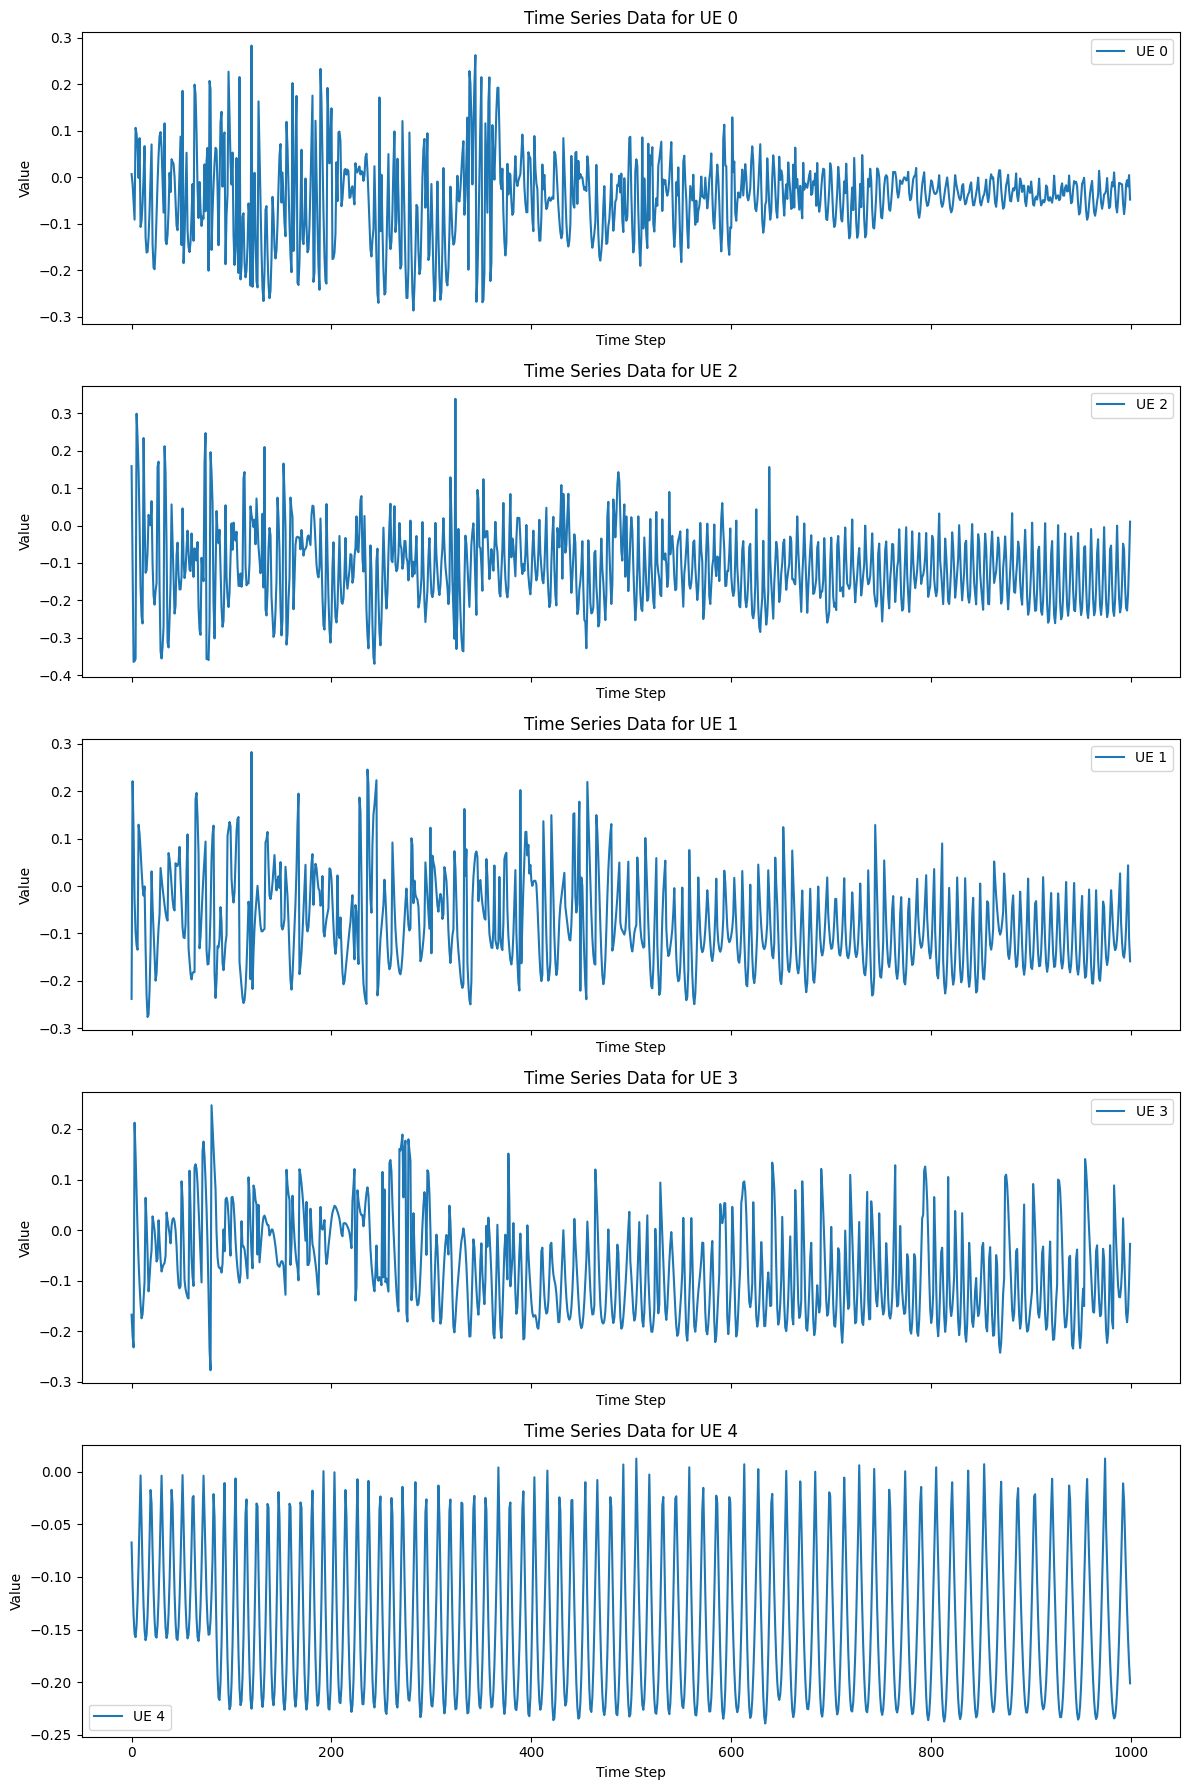

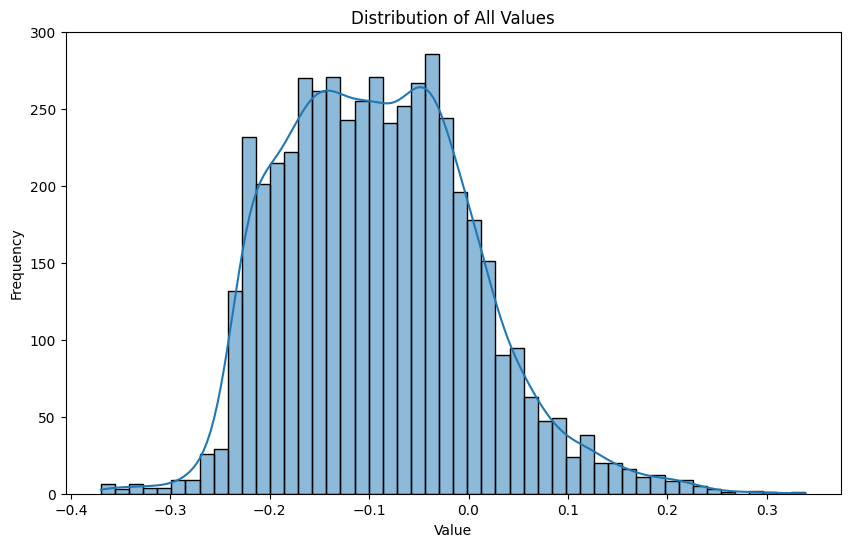

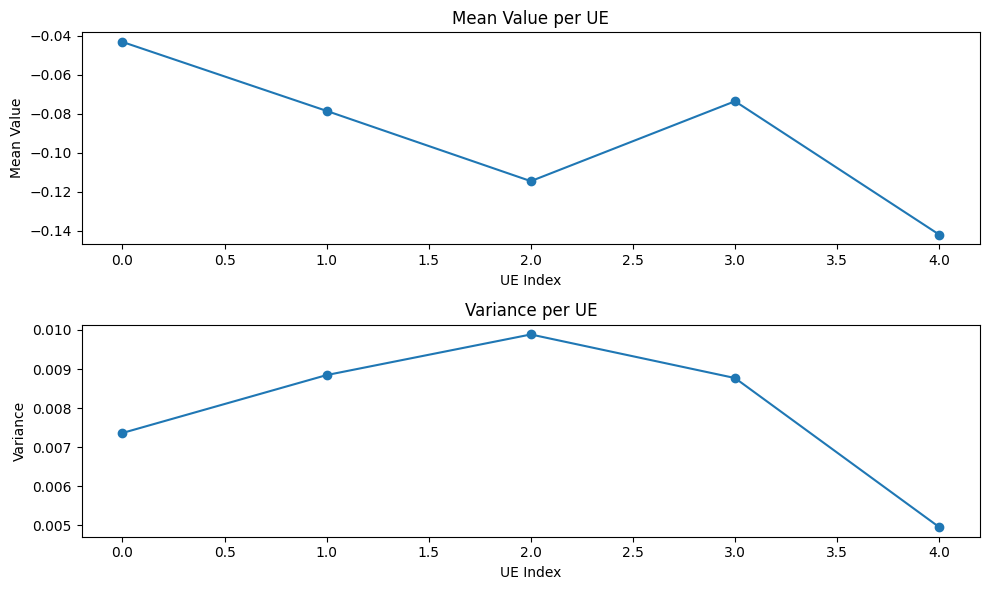

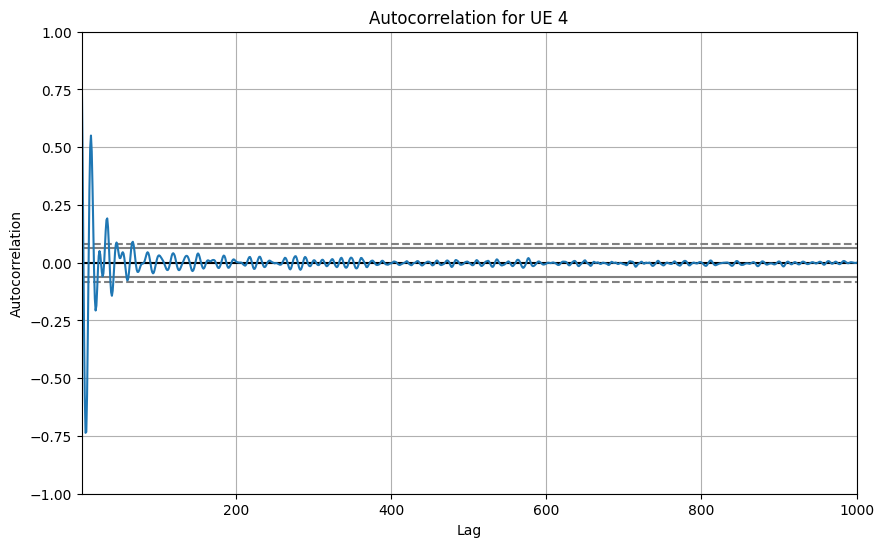

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Assuming `data` is already loaded as a numpy array with shape (2100, 101888)
num_UEs = data.shape[0]
num_time_steps = data.shape[1]

# Set the number of samples to analyze
num_samples_to_plot = 5

# Choose random UEs to visualize
random_indices = random.sample(range(num_UEs), num_samples_to_plot)

# Visualize the time series data of a few UEs
fig, axs = plt.subplots(num_samples_to_plot, 1, figsize=(12, 18), sharex=True)
for i, idx in enumerate(random_indices):
    axs[i].plot(data[idx, :], label=f'UE {idx}')
    axs[i].set_title(f'Time Series Data for UE {idx}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Value')
    axs[i].legend()
plt.tight_layout()
plt.show()

# Plot the distribution of values across all UEs
flat_data = data.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(flat_data, bins=50, kde=True)
plt.title('Distribution of All Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Plot the mean and variance for each UE
mean_values = np.mean(data, axis=1)
var_values = np.var(data, axis=1)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(mean_values, 'o-')
plt.title('Mean Value per UE')
plt.xlabel('UE Index')
plt.ylabel('Mean Value')

plt.subplot(2, 1, 2)
plt.plot(var_values, 'o-')
plt.title('Variance per UE')
plt.xlabel('UE Index')
plt.ylabel('Variance')
plt.tight_layout()
plt.show()

# Analyze autocorrelation of a random UE
from pandas.plotting import autocorrelation_plot

random_ue = random.choice(range(num_UEs))
plt.figure(figsize=(10, 6))
autocorrelation_plot(data[random_ue, :])
plt.title(f'Autocorrelation for UE {random_ue}')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


In [13]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming data has shape (2100, 101888), where the first 10 values are inputs and the 11th value is the target
num_UEs = data.shape[0]
input_length = 10

# Simplified ARIMA order for faster training
arima_order = (1, 0, 1)  # Example: p=1, d=0, q=1

# Lists to store evaluation results
mse_results = []

# Progress bar for all UEs
for ue_idx in tqdm(range(num_UEs), desc="Processing UEs", unit="UE"):
    ue_data = data[ue_idx]

    # Split into training (80%) and testing (20%) sets
    split_idx = int(0.8 * len(ue_data))
    train_data = ue_data[:split_idx]
    test_data = ue_data[split_idx:]

    # Initialize variables to store predictions
    history = list(train_data)
    predictions = []

    # Process predictions in each UE
    for t in range(len(test_data)):
        # Define ARIMA model with the simplified order
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Add actual value to history
        history.append(test_data[t])

        # Optionally, print progress every 10% to see where we are
        if t % (len(test_data) // 10 + 1) == 0:
            tqdm.write(f'UE {ue_idx}: Progress {t / len(test_data) * 100:.1f}%')

    # Calculate mean squared error for this UE
    mse = mean_squared_error(test_data, predictions)
    mse_results.append(mse)
    tqdm.write(f'UE {ue_idx}: Mean Squared Error = {mse:.3f}')

# Output average MSE across all UEs
average_mse = np.mean(mse_results)
print(f'Average Mean Squared Error across all UEs: {average_mse:.3f}')

Processing UEs:   0%|          | 0/5 [00:00<?, ?UE/s]

UE 0: Progress 0.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:   0%|          | 0/5 [00:02<?, ?UE/s]

UE 0: Progress 10.5%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:   0%|          | 0/5 [00:05<?, ?UE/s]

UE 0: Progress 21.0%


Processing UEs:   0%|          | 0/5 [00:08<?, ?UE/s]

UE 0: Progress 31.5%


Processing UEs:   0%|          | 0/5 [00:11<?, ?UE/s]

UE 0: Progress 42.0%


Processing UEs:   0%|          | 0/5 [00:13<?, ?UE/s]

UE 0: Progress 52.5%


Processing UEs:   0%|          | 0/5 [00:16<?, ?UE/s]

UE 0: Progress 63.0%


Processing UEs:   0%|          | 0/5 [00:19<?, ?UE/s]

UE 0: Progress 73.5%


Processing UEs:   0%|          | 0/5 [00:21<?, ?UE/s]

UE 0: Progress 84.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:   0%|          | 0/5 [00:25<?, ?UE/s]

UE 0: Progress 94.5%


Processing UEs:  20%|██        | 1/5 [00:26<01:46, 26.54s/UE]

UE 0: Mean Squared Error = 0.000
UE 1: Progress 0.0%


Processing UEs:  20%|██        | 1/5 [00:28<01:46, 26.54s/UE]

UE 1: Progress 10.5%


Processing UEs:  20%|██        | 1/5 [00:31<01:46, 26.54s/UE]

UE 1: Progress 21.0%


Processing UEs:  20%|██        | 1/5 [00:33<01:46, 26.54s/UE]

UE 1: Progress 31.5%


Processing UEs:  20%|██        | 1/5 [00:36<01:46, 26.54s/UE]

UE 1: Progress 42.0%


Processing UEs:  20%|██        | 1/5 [00:38<01:46, 26.54s/UE]

UE 1: Progress 52.5%


Processing UEs:  20%|██        | 1/5 [00:41<01:46, 26.54s/UE]

UE 1: Progress 63.0%


Processing UEs:  20%|██        | 1/5 [00:44<01:46, 26.54s/UE]

UE 1: Progress 73.5%


Processing UEs:  20%|██        | 1/5 [00:46<01:46, 26.54s/UE]

UE 1: Progress 84.0%


Processing UEs:  20%|██        | 1/5 [00:49<01:46, 26.54s/UE]

UE 1: Progress 94.5%


Processing UEs:  40%|████      | 2/5 [00:51<01:16, 25.54s/UE]

UE 1: Mean Squared Error = 0.003


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  40%|████      | 2/5 [00:51<01:16, 25.54s/UE]

UE 2: Progress 0.0%


Processing UEs:  40%|████      | 2/5 [00:54<01:16, 25.54s/UE]

UE 2: Progress 10.5%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  40%|████      | 2/5 [00:56<01:16, 25.54s/UE]

UE 2: Progress 21.0%


Processing UEs:  40%|████      | 2/5 [00:59<01:16, 25.54s/UE]

UE 2: Progress 31.5%


Processing UEs:  40%|████      | 2/5 [01:02<01:16, 25.54s/UE]

UE 2: Progress 42.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  40%|████      | 2/5 [01:05<01:16, 25.54s/UE]

UE 2: Progress 52.5%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  40%|████      | 2/5 [01:08<01:16, 25.54s/UE]

UE 2: Progress 63.0%


Processing UEs:  40%|████      | 2/5 [01:11<01:16, 25.54s/UE]

UE 2: Progress 73.5%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  40%|████      | 2/5 [01:14<01:16, 25.54s/UE]

UE 2: Progress 84.0%


Processing UEs:  40%|████      | 2/5 [01:17<01:16, 25.54s/UE]

UE 2: Progress 94.5%


Processing UEs:  60%|██████    | 3/5 [01:19<00:52, 26.45s/UE]

UE 2: Mean Squared Error = 0.003
UE 3: Progress 0.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  60%|██████    | 3/5 [01:21<00:52, 26.45s/UE]

UE 3: Progress 10.5%


Processing UEs:  60%|██████    | 3/5 [01:24<00:52, 26.45s/UE]

UE 3: Progress 21.0%


Processing UEs:  60%|██████    | 3/5 [01:27<00:52, 26.45s/UE]

UE 3: Progress 31.5%


Processing UEs:  60%|██████    | 3/5 [01:30<00:52, 26.45s/UE]

UE 3: Progress 42.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  60%|██████    | 3/5 [01:34<00:52, 26.45s/UE]

UE 3: Progress 52.5%


Processing UEs:  60%|██████    | 3/5 [01:37<00:52, 26.45s/UE]

UE 3: Progress 63.0%


Processing UEs:  60%|██████    | 3/5 [01:40<00:52, 26.45s/UE]

UE 3: Progress 73.5%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  60%|██████    | 3/5 [01:44<00:52, 26.45s/UE]

UE 3: Progress 84.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  60%|██████    | 3/5 [01:47<00:52, 26.45s/UE]

UE 3: Progress 94.5%


Processing UEs:  80%|████████  | 4/5 [01:49<00:27, 27.91s/UE]

UE 3: Mean Squared Error = 0.004
UE 4: Progress 0.0%


Processing UEs:  80%|████████  | 4/5 [01:53<00:27, 27.91s/UE]

UE 4: Progress 10.5%


Processing UEs:  80%|████████  | 4/5 [01:56<00:27, 27.91s/UE]

UE 4: Progress 21.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  80%|████████  | 4/5 [01:59<00:27, 27.91s/UE]

UE 4: Progress 31.5%


Processing UEs:  80%|████████  | 4/5 [02:02<00:27, 27.91s/UE]

UE 4: Progress 42.0%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing UEs:  80%|████████  | 4/5 [02:06<00:27, 27.91s/UE]

UE 4: Progress 52.5%


Processing UEs:  80%|████████  | 4/5 [02:10<00:27, 27.91s/UE]

UE 4: Progress 63.0%


Processing UEs:  80%|████████  | 4/5 [02:14<00:27, 27.91s/UE]

UE 4: Progress 73.5%


Processing UEs:  80%|████████  | 4/5 [02:17<00:27, 27.91s/UE]

UE 4: Progress 84.0%


Processing UEs:  80%|████████  | 4/5 [02:21<00:27, 27.91s/UE]

UE 4: Progress 94.5%


Processing UEs: 100%|██████████| 5/5 [02:23<00:00, 28.68s/UE]

UE 4: Mean Squared Error = 0.000
Average Mean Squared Error across all UEs: 0.002


In [14]:
import pandas as pd

# Function to tabulate actual and predicted values for one UE
def tabulate_predictions(ue_idx):
    ue_data = data[ue_idx]
    split_idx = int(0.8 * len(ue_data))
    train_data = ue_data[:split_idx]
    test_data = ue_data[split_idx:]

    # Initialize history from training data
    history = list(train_data)
    predictions = []

    # Train and forecast for each test point
    for t in range(len(test_data)):
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit()

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Add actual value to history
        history.append(test_data[t])

    # Create a DataFrame to compare actual and predicted values
    results_df = pd.DataFrame({
        'Actual': test_data,
        'Predicted': predictions
    })

    return results_df

# Example usage for a single UE (replace `0` with a specific UE index to inspect)
ue_idx_to_inspect = 0
predictions_table = tabulate_predictions(ue_idx_to_inspect)

# Display the first few rows of the predictions table
print(predictions_table.head())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


     Actual  Predicted
0 -0.006917  -0.037354
1 -0.011221  -0.030289
2 -0.025651  -0.033798
3 -0.034059  -0.039283
4 -0.036438  -0.041674


In [15]:
import matplotlib.pyplot as plt

# Function to visualize the actual and predicted values for one UE
def visualize_predictions(ue_idx):
    ue_data = data[ue_idx]
    split_idx = int(0.8 * len(ue_data))
    train_data = ue_data[:split_idx]
    test_data = ue_data[split_idx:]

    # Initialize history from training data
    history = list(train_data)
    predictions = []

    # Train and forecast for each test point
    for t in range(len(test_data)):
        model = ARIMA(history, order=(1, 0, 1))
        model_fit = model.fit()

        # Forecast the next value
        forecast = model_fit.forecast()[0]
        predictions.append(forecast)

        # Add actual value to history
        history.append(test_data[t])

    # Plot the actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data, label='Actual', marker='o', linestyle='--')
    plt.plot(predictions, label='Predicted', marker='x', linestyle='-')
    plt.title(f'UE {ue_idx}: Actual vs. Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

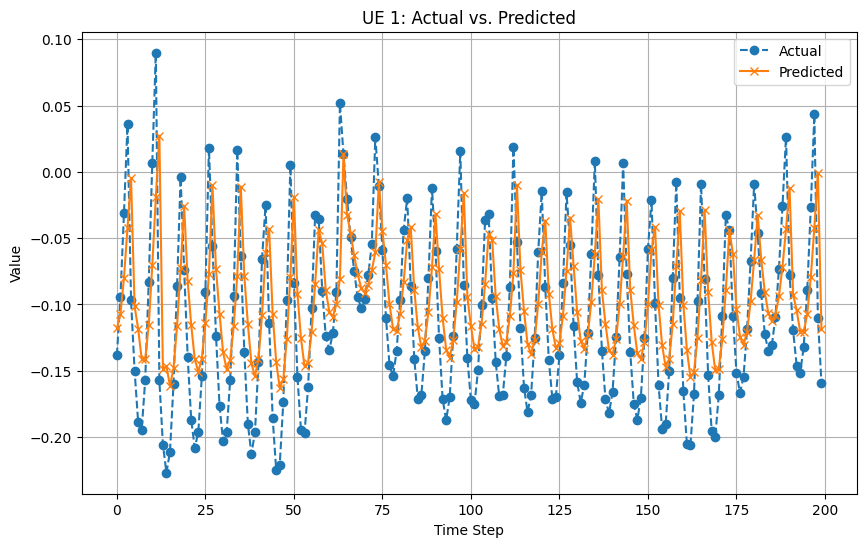

In [19]:
# Example usage for a single UE (replace `0` with a specific UE index to visualize)
visualize_predictions(1)